# Library

In [ ]:
# !pip install datasets
!pip install tokenizers
# !pip install transformers

!pip install datasets transformers==4.28.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 74.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 83.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.5 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.14.1
    Uninstalling tokenizers-0.14.1:
      Successfully uninstalled tokenizers-0.14.1


In [ ]:
!pip3 install tokenizers

In [ ]:
!pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=569e87a91fbaae064e08561ea88600f00cb244a4a2a570879c87d2aae0bbacb2
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline
from transformers import DataCollatorWithPadding,AutoModelForSequenceClassification, Trainer, TrainingArguments,AutoTokenizer,AutoModel,AutoConfig, DataCollatorForTokenClassification
from transformers.modeling_outputs import TokenClassifierOutput
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import datasets
from datasets import load_dataset,Dataset,DatasetDict,ClassLabel,Sequence

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load and process custom dataset

In [ ]:
df = pd.read_csv('/content/combined_BIO.csv')

In [ ]:
import ast

# Function to process the label column
def process_label(label):
    # Use ast.literal_eval to safely evaluate the content inside the brackets
    try:
        label_list = ast.literal_eval(label)
        if isinstance(label_list, list):
            if len(label_list) == 0:
                return [0]
            return label_list
    except (SyntaxError, ValueError):
        pass
    return [0]

In [ ]:
df['content'] = df['content'].str.replace(r"[\[\]']", '', regex=True)

In [ ]:
df['content'] = df['content'].apply(lambda x: x.split(" "))

In [ ]:
# Apply the process_label function to each row in the label column
df['NER'] = df['NER'].apply(lambda x: x.replace("[[", "["))
df['NER'] = df['NER'].apply(lambda x: x.replace("]]", "]"))
df['NER'] = df['NER'].apply(process_label)


# Explode the label lists into separate rows
# df = df.explode('label', ignore_index=True)
# df = df.drop(['Unnamed: 0'], axis=1)

In [ ]:
df.rename(columns = {'content': 'tokens', 'NER':'ner_tags'}, inplace = True)

In [ ]:
df = df.drop(['Unnamed: 0', 'label'], axis=1)

In [ ]:
data = Dataset.from_pandas(df)

In [ ]:
class_label = ["O", "B-Subject", "I-Subject", "B-Object", "I-Object", "B-Aspect", "I-Aspect", "B-Predicate", "I-Predicate"]
data = data.cast_column("ner_tags", datasets.Sequence(datasets.ClassLabel(names=class_label)))

Casting the dataset:   0%|          | 0/4807 [00:00<?, ? examples/s]

In [ ]:
train_testvalid = data.train_test_split(test_size=0.2,seed=15)

# Split the 10% test + valid in half test, half valid
test_valid = train_testvalid['test'].train_test_split(test_size=0.5,seed=15)
dataset = DatasetDict({
    'train': train_testvalid['train'],
    'test': test_valid['test'],
    'validation': test_valid['train']})

In [ ]:
label_names = dataset["train"].features["ner_tags"].feature.names

# Huggingface preprocessing

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("NlpHUST/ner-vietnamese-electra-base")

#Get the values for input_ids, token_type_ids, attention_mask
def tokenize_adjust_labels(all_samples_per_split):
  tokenized_samples = tokenizer.batch_encode_plus(all_samples_per_split["tokens"], is_split_into_words=True)
  #tokenized_samples is not a datasets object so this alone won't work with Trainer API, hence map is used
  #so the new keys [input_ids, labels (after adjustment)]
  #can be added to the datasets dict for each train test validation split
  total_adjusted_labels = []
  print(len(tokenized_samples["input_ids"]))
  for k in range(0, len(tokenized_samples["input_ids"])):
    prev_wid = -1
    word_ids_list = tokenized_samples.word_ids(batch_index=k)
    existing_label_ids = all_samples_per_split["ner_tags"][k]
    i = -1
    adjusted_label_ids = []

    for wid in word_ids_list:
      if(wid is None):
        adjusted_label_ids.append(-100)
      elif(wid!=prev_wid):
        i = i + 1
        adjusted_label_ids.append(existing_label_ids[i])
        prev_wid = wid
      else:
        label_name = label_names[existing_label_ids[i]]
        adjusted_label_ids.append(existing_label_ids[i])

    total_adjusted_labels.append(adjusted_label_ids)
  tokenized_samples["labels"] = total_adjusted_labels
  return tokenized_samples

tokenized_dataset = dataset.map(tokenize_adjust_labels, batched=True)

Map:   0%|          | 0/3845 [00:00<?, ? examples/s]

1000
1000
1000
845


Map:   0%|          | 0/481 [00:00<?, ? examples/s]

481


Map:   0%|          | 0/481 [00:00<?, ? examples/s]

481


In [ ]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer)

In [ ]:
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer
import numpy as np
from datasets import load_metric

In [ ]:
metric = load_metric("seqeval")

<ipython-input-21-e20ba34f8cc7>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("seqeval")


In [ ]:
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_names[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    flattened_results = {
        "overall_precision": results["overall_precision"],
        "overall_recall": results["overall_recall"],
        "overall_f1": results["overall_f1"],
        "overall_accuracy": results["overall_accuracy"],
    }
    for k in results.keys():
      if(k not in flattened_results.keys()):
        flattened_results[k+"_f1"]=results[k]["f1"]

    return flattened_results

In [ ]:
len(label_names)

9

In [ ]:
id2label = {0: "O", 1: "B-Subject", 2: "I-Subject", 3: "B-Object", 4: "I-Object", 5: "B-Aspect", 6: "B-Aspect",
            7: "B-Predicate", 8: "I-Predicate"}

label2id = {"O": 0 , "B-Subject": 1, "I-Subject": 2 , "B-Object": 3, "I-Object": 4, "B-Aspect": 5, "B-Aspect": 6,
            "B-Predicate": 7, "I-Predicate": 8}

In [ ]:
model = AutoModelForTokenClassification.from_pretrained("NlpHUST/ner-vietnamese-electra-base", num_labels=len(label_names), id2label=id2label, label2id=label2id)


In [ ]:
# for name, module in model.named_modules():
#   print(name)


electra
electra.embeddings
electra.embeddings.word_embeddings
electra.embeddings.position_embeddings
electra.embeddings.token_type_embeddings
electra.embeddings.LayerNorm
electra.embeddings.dropout
electra.encoder
electra.encoder.layer
electra.encoder.layer.0
electra.encoder.layer.0.attention
electra.encoder.layer.0.attention.self
electra.encoder.layer.0.attention.self.query
electra.encoder.layer.0.attention.self.key
electra.encoder.layer.0.attention.self.value
electra.encoder.layer.0.attention.self.dropout
electra.encoder.layer.0.attention.output
electra.encoder.layer.0.attention.output.dense
electra.encoder.layer.0.attention.output.LayerNorm
electra.encoder.layer.0.attention.output.dropout
electra.encoder.layer.0.intermediate
electra.encoder.layer.0.intermediate.dense
electra.encoder.layer.0.intermediate.intermediate_act_fn
electra.encoder.layer.0.output
electra.encoder.layer.0.output.dense
electra.encoder.layer.0.output.LayerNorm
electra.encoder.layer.0.output.dropout
electra.encod

In [ ]:
# for name, module in model.named_modules():
#   freeze_list = [".embeddings", ".layer.0.", ".layer.1.", ".layer.2.", ".layer.3.", ".layer.4."]
#   for layer in freeze_list:
#     if layer in name:
#       for param in module.parameters():
#         param.requires_grad = False

In [ ]:
# for name, module in model.named_modules():
#     for param in module.parameters():
#         if param.requires_grad == True:
#           print(name)
#           break


electra
electra.encoder
electra.encoder.layer
electra.encoder.layer.4
electra.encoder.layer.4.attention
electra.encoder.layer.4.attention.self
electra.encoder.layer.4.attention.self.query
electra.encoder.layer.4.attention.self.key
electra.encoder.layer.4.attention.self.value
electra.encoder.layer.4.attention.output
electra.encoder.layer.4.attention.output.dense
electra.encoder.layer.4.attention.output.LayerNorm
electra.encoder.layer.4.intermediate
electra.encoder.layer.4.intermediate.dense
electra.encoder.layer.4.output
electra.encoder.layer.4.output.dense
electra.encoder.layer.4.output.LayerNorm
electra.encoder.layer.5
electra.encoder.layer.5.attention
electra.encoder.layer.5.attention.self
electra.encoder.layer.5.attention.self.query
electra.encoder.layer.5.attention.self.key
electra.encoder.layer.5.attention.self.value
electra.encoder.layer.5.attention.output
electra.encoder.layer.5.attention.output.dense
electra.encoder.layer.5.attention.output.LayerNorm
electra.encoder.layer.5.in

In [ ]:
model.num_parameters(only_trainable = True)

49622025

In [ ]:
model.num_parameters(only_trainable = False)

133073673

In [ ]:
batch_size = 128
training_args = TrainingArguments(
output_dir="results",
num_train_epochs=40,
per_device_train_batch_size=batch_size,
per_device_eval_batch_size=batch_size,
evaluation_strategy="epoch",
disable_tqdm=False,
logging_steps=len(tokenized_dataset['train']) // batch_size)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a ElectraTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Overall Precision,Overall Recall,Overall F1,Overall Accuracy,Aspect F1,Object F1,Predicate F1,Subject F1
1,2.740400,0.643881,0.423688,0.485649,0.452558,0.788322,0.404539,0.328152,0.552394,0.452640
2,0.432100,0.254490,0.748652,0.822323,0.783760,0.923092,0.758287,0.754783,0.807799,0.800349
3,0.206700,0.156064,0.840742,0.887472,0.863475,0.954857,0.835517,0.818342,0.900494,0.873484
4,0.113800,0.128984,0.880952,0.910251,0.895362,0.965204,0.871607,0.875000,0.918498,0.905226
5,0.074900,0.111067,0.894967,0.931663,0.912946,0.970805,0.912152,0.876522,0.939007,0.899911
6,0.051200,0.095132,0.923214,0.942141,0.932582,0.976012,0.922049,0.921960,0.950820,0.927690
7,0.039500,0.095624,0.921847,0.945786,0.933663,0.977066,0.917526,0.920354,0.952790,0.936057
8,0.027600,0.087966,0.921708,0.943964,0.932703,0.977857,0.923304,0.911032,0.952722,0.930027
9,0.020100,0.079623,0.928762,0.950342,0.939428,0.980822,0.933135,0.927176,0.953538,0.935569
10,0.020100,0.088553,0.935354,0.955809,0.945471,0.980032,0.932642,0.942652,0.959198,0.945230


TrainOutput(global_step=1240, training_loss=0.09395604309430647, metrics={'train_runtime': 1916.3782, 'train_samples_per_second': 80.256, 'train_steps_per_second': 0.647, 'total_flos': 6295064796272484.0, 'train_loss': 0.09395604309430647, 'epoch': 40.0})

In [ ]:
predictions, labels, _ = trainer.predict(tokenized_dataset["test"])

predictions = np.argmax(predictions, axis=2)

# Remove ignored index (special tokens)

true_predictions = [

[label_names[p] for (p, l) in zip(prediction, label) if l != -100]

for prediction, label in zip(predictions, labels)

]

true_labels = [

[label_names[l] for (p, l) in zip(prediction, label) if l != -100]

for prediction, label in zip(predictions, labels)

]

results = metric.compute(predictions=true_predictions, references=true_labels)

results

{'Aspect': {'precision': 0.9276923076923077,
  'recall': 0.9481132075471698,
  'f1': 0.9377916018662519,
  'number': 636},
 'Object': {'precision': 0.931899641577061,
  'recall': 0.966542750929368,
  'f1': 0.9489051094890512,
  'number': 269},
 'Predicate': {'precision': 0.967605633802817,
  'recall': 0.9800285306704708,
  'f1': 0.9737774627923459,
  'number': 701},
 'Subject': {'precision': 0.9531772575250836,
  'recall': 0.946843853820598,
  'f1': 0.95,
  'number': 602},
 'overall_precision': 0.9476978095663835,
 'overall_recall': 0.9601449275362319,
 'overall_f1': 0.9538807649043869,
 'overall_accuracy': 0.9857813806858393}

In [ ]:
trainer.save_model("/content/drive/MyDrive/baseline_models/electra_new_data")

In [ ]:
len(trainer.state.log_history)

41

In [ ]:
import matplotlib.pyplot as plt

loss_list = []
val_loss_list = []
for i in range(0, len(trainer.state.log_history)):
  if "eval_loss" in trainer.state.log_history[i].keys():
    val_loss_list.append(trainer.state.log_history[i]["eval_loss"])
  if "loss" in trainer.state.log_history[i].keys():
    loss_list.append(trainer.state.log_history[i]["loss"])
  if "eval_loss" in trainer.state.log_history[i].keys() and "loss" in trainer.state.log_history[i].keys():
    print(trainer.state.log_history[i])

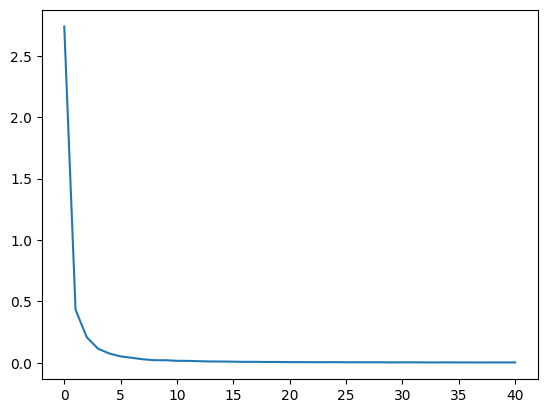

In [ ]:
plt.plot(loss_list)

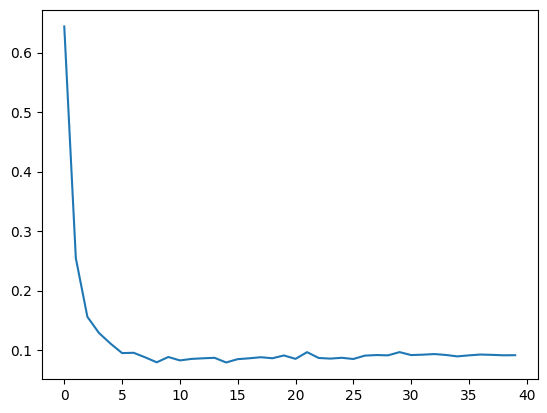

In [ ]:
plt.plot(val_loss_list)

# Inference

In [ ]:
from transformers import pipeline
from transformers import AutoTokenizer


tokenizer = AutoTokenizer.from_pretrained("NlpHUST/ner-vietnamese-electra-base")
model_test = AutoModelForTokenClassification.from_pretrained("/content/drive/MyDrive/baseline_models/electra_new_data")
nlp = pipeline("token-classification", model=model_test, tokenizer=tokenizer)
example = "điện thoại A tốt hơn điện thoại B ."
ner_results = nlp(example)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [ ]:
ner_results

[{'entity': 'B-Subject',
  'score': 0.9995492,
  'index': 1,
  'word': 'điê',
  'start': 0,
  'end': 3},
 {'entity': 'B-Subject',
  'score': 0.9993622,
  'index': 2,
  'word': '##̣',
  'start': 3,
  'end': 4},
 {'entity': 'B-Subject',
  'score': 0.9995889,
  'index': 3,
  'word': '##n',
  'start': 4,
  'end': 5},
 {'entity': 'I-Subject',
  'score': 0.9993875,
  'index': 4,
  'word': 'thoa',
  'start': 6,
  'end': 10},
 {'entity': 'I-Subject',
  'score': 0.9991673,
  'index': 5,
  'word': '##̣',
  'start': 10,
  'end': 11},
 {'entity': 'I-Subject',
  'score': 0.9989951,
  'index': 6,
  'word': '##i',
  'start': 11,
  'end': 12},
 {'entity': 'I-Subject',
  'score': 0.99935037,
  'index': 7,
  'word': 'A',
  'start': 13,
  'end': 14},
 {'entity': 'B-Predicate',
  'score': 0.9993724,
  'index': 8,
  'word': 'tô',
  'start': 15,
  'end': 17},
 {'entity': 'B-Predicate',
  'score': 0.9993789,
  'index': 9,
  'word': '##́',
  'start': 17,
  'end': 18},
 {'entity': 'B-Predicate',
  'score': 0.9

In [ ]:
model_test.num_parameters()

133073673

In [ ]:
model_test.num_parameters(only_trainable = True)

133073673

In [ ]:
model_test.num_parameters(only_trainable = False)

133073673

In [ ]:
ner_results

[{'entity': 'B-Subject',
  'score': 0.98855746,
  'index': 1,
  'word': 'iPhone',
  'start': 0,
  'end': 6},
 {'entity': 'I-Subject',
  'score': 0.9809686,
  'index': 2,
  'word': '14',
  'start': 7,
  'end': 9},
 {'entity': 'I-Subject',
  'score': 0.9936767,
  'index': 3,
  'word': 'Pro',
  'start': 10,
  'end': 13},
 {'entity': 'I-Subject',
  'score': 0.99559397,
  'index': 4,
  'word': 'Max',
  'start': 14,
  'end': 17},
 {'entity': 'B-Object',
  'score': 0.97260094,
  'index': 8,
  'word': 'Google',
  'start': 28,
  'end': 34},
 {'entity': 'I-Object',
  'score': 0.9933867,
  'index': 9,
  'word': 'Pixel',
  'start': 35,
  'end': 40},
 {'entity': 'I-Object',
  'score': 0.9938904,
  'index': 10,
  'word': '7',
  'start': 41,
  'end': 42},
 {'entity': 'I-Object',
  'score': 0.9926891,
  'index': 11,
  'word': 'Pro',
  'start': 43,
  'end': 46},
 {'entity': 'B-Predicate',
  'score': 0.979772,
  'index': 12,
  'word': 'đê',
  'start': 47,
  'end': 49},
 {'entity': 'B-Predicate',
  'scor